# Introduction to scikit-learn

We would like to introduce you to scikit-learn with the help of an instructional example about text classification. We will cover the most basic principles and ideas about scikit-learn in this notebook. This tutorial is inspired by the sklearn tutorial on http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html, but contains a few more explanations and is suited to introduce scikit-learn in class.

$Author$: Phillip Ströbel (changes by Tilia Ellendorff)

## Data

Get the data from http://qwone.com/~jason/20Newsgroups/. We will work with the **20news-bydate.tar.gz** data set. - Unzip it to a suitable destination. Here, all the data lies in the data folder. It has already been split into a training and a test set, so we don't have to care about this. What we need to do though is get the data and put it into a dataframe (you could also only work with dictionaries or other data containers). We do this for both the training and the test set.

In [1]:
import os
import codecs
import pandas as pd

def create_df(path_to_data, categories=[], shuffle=True, random_state=42):
    """
    takes the path of a folder containing all the subfolders (which contain the acutal documents). builds a pandas datafram with document ids, the text and the label. shuffled is default.
    :param path_to_data: path to top folder as a string
    :param categories: categories which should be in the dataframe as list of strings, default is all categories
    :param shuffle: boolean, determines whether data should be shuffled or not
    :param random_state: integer, seed for shuffling
    :return: pandas dataframe with all th
    """
    
    doc_list = list()
    
    if categories == []:
        for category in os.listdir(path_to_data):
            for document in os.listdir(os.path.join(path_to_data, category)):
                doc = codecs.open(os.path.join(path_to_data, category, document), 'r', 'latin-1').read().replace('\n', ' ')
                doc_list.append([doc, category])
    else:
        for category in categories:
            for document in os.listdir(os.path.join(path_to_data, category)):
                doc = codecs.open(os.path.join(path_to_data, category, document), 'r', 'latin-1').read().replace('\n', ' ')
                doc_list.append([doc, category])
    
    df = pd.DataFrame(doc_list, columns=['text', 'label'])

    return df.sample(frac=1, random_state=random_state)
            

In [4]:
%cd ~/Desktop/

/Users/tilia/Desktop


In [5]:
train = create_df('data/20news-bydate/20news-bydate-train')
test = create_df('data/20news-bydate/20news-bydate-test')

In [6]:
print('training size: ', train.shape)
print('test size: ', test.shape)

training size:  (11314, 2)
test size:  (7532, 2)


In [8]:
# look at the first few rows of the dataframe

train.head()

,text,label
7492,From: wtm@uhura.neoucom.edu (Bill Mayhew) Subj...,sci.electronics
3546,From: andy@SAIL.Stanford.EDU (Andy Freeman) Su...,misc.forsale
5582,From: cs1442aq@news.uta.edu (cs1442aq) Subject...,rec.sport.baseball
4793,From: cjackson@adobe.com (Curtis Jackson) Subj...,rec.motorcycles
3813,From: frp@table.NSD.3Com.COM (Frank R. Pereira...,misc.forsale


In [7]:
# get short overview of frequency measures for the dataframe

train.describe()

,text,label
count,11314,11314
unique,11314,20
top,From: koontzd@phobos.lrmsc.loral.com (David Ko...,rec.sport.hockey
freq,1,600


In [9]:
# get label distribution

train.groupby('label').size()

label
alt.atheism                 480
comp.graphics               584
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
comp.sys.mac.hardware       578
comp.windows.x              593
misc.forsale                585
rec.autos                   594
rec.motorcycles             598
rec.sport.baseball          597
rec.sport.hockey            600
sci.crypt                   595
sci.electronics             591
sci.med                     594
sci.space                   593
soc.religion.christian      599
talk.politics.guns          546
talk.politics.mideast       564
talk.politics.misc          465
talk.religion.misc          377
dtype: int64

We retrieve the labels from the training and the test set.

In [11]:
X_train = train.text
y_train = train.label
X_test = test.text
y_test = test.label

Let's see if we got this right.

In [12]:
print('Training set shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test set shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training set shape:  (11314,)
Training labels shape:  (11314,)
Test set shape:  (7532,)
Test labels shape:  (7532,)


In [14]:
X_train.head()

7492    From: wtm@uhura.neoucom.edu (Bill Mayhew) Subj...
3546    From: andy@SAIL.Stanford.EDU (Andy Freeman) Su...
5582    From: cs1442aq@news.uta.edu (cs1442aq) Subject...
4793    From: cjackson@adobe.com (Curtis Jackson) Subj...
3813    From: frp@table.NSD.3Com.COM (Frank R. Pereira...
Name: text, dtype: object

## Preprocessing
Machine learning algorithms cannot work with text data directly. So we need to vectorise the data somehow. Also, we want to do some preprocessing.
### Vectorise the data 
Sklearn offers helpful classes for preprocessing and vectorization: 
`CountVectoriser()` tokenises the data and then vectorises it.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

The central methods in sklearn are `transform`, `fit`, `fit_transform`, and `predict`. We will see how each of these work and when to use them. We have alredy made use of `fit_transform`. Instead of using this method, we could have called the method `fit` first and the use `transform` to vectorise the data (to 'transform' it). With the fitted `CountVectorizer` we can now also transform the test set.

In [45]:
X_test_counts = count_vect.transform(X_test)

We will return to this later. First let us see what `CountVectorizer` produces.

In [75]:
X_train_counts

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

The vectorised form contains 11314 rows, which is the number of our documents, while the number of columns tells us something about the vocabulary size of the whole corpus. But what's a sparse matrix? Note that saving the complete, sparse document-vocabulary matrix would need to hold 1,472,030,598 values, most of which would be zero? Why? Instead, we only save 1,787,565 values in a compressed sparse row format. An example:

In [16]:
import numpy as np
from scipy import sparse

row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
mtx = sparse.csr_matrix((data, (row, col)), shape=(3, 3))
mtx      

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [17]:
mtx.todense()

matrix([[1, 0, 2],
        [0, 0, 3],
        [4, 5, 6]], dtype=int64)

In [84]:
X_train_counts.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
X_train_counts.shape

(11314, 130107)

In [29]:
X_train_counts[0,:]

<1x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 132 stored elements in Compressed Sparse Row format>

For one training example, we can look up which positions of the document vector are occupied. A `1` means the word occurs once in the document (i.e. each number gives the exact count).

In [31]:
print(X_train_counts[0,:])

  (0, 85829)	1
  (0, 15599)	1
  (0, 4469)	1
  (0, 8926)	1
  (0, 4156)	1
  (0, 9725)	1
  (0, 11676)	1
  (0, 8861)	1
  (0, 93582)	1
  (0, 119714)	1
  (0, 22455)	1
  (0, 13703)	1
  (0, 89496)	1
  (0, 102933)	1
  (0, 46364)	1
  (0, 106253)	1
  (0, 41614)	1
  (0, 41444)	1
  (0, 106030)	1
  (0, 71079)	1
  (0, 124332)	1
  (0, 47721)	1
  (0, 96346)	1
  (0, 90642)	1
  (0, 119781)	1
  :	:
  (0, 125265)	1
  (0, 9221)	1
  (0, 76032)	1
  (0, 80816)	1
  (0, 89362)	6
  (0, 40998)	1
  (0, 118981)	1
  (0, 89513)	1
  (0, 87905)	1
  (0, 90379)	1
  (0, 96493)	1
  (0, 42597)	2
  (0, 47729)	1
  (0, 114455)	12
  (0, 115475)	6
  (0, 64186)	1
  (0, 99721)	2
  (0, 111322)	1
  (0, 80016)	2
  (0, 33331)	2
  (0, 50527)	2
  (0, 86642)	3
  (0, 118043)	2
  (0, 125402)	2
  (0, 56979)	1


From this, we can get the number of words in a document.

In [85]:
X_train_counts[1,:].sum()

263

Similarly, we can count how many times a certain word occurs across all documents.

In [33]:
X_train_counts[:,0].sum()

1534

We can also find out how many times a specific word occurs in the corpus. First, we need to find the index (i.e. the column in the feature matrix):

In [86]:
count_vect.vocabulary_.get(u'cat')

38082

Now we have the index, we can count how many times the word "sin" occurs in our corpus.

In [88]:
sin_index = count_vect.vocabulary_.get(u'cat')
X_train_counts[:,sin_index].sum()

116

`CountVectorizer` also lets you also define if you want to count bigrams, or other n-grams. Moreover, you can not only count words, but als characters. We suggest you try these out for yourself. In the following, we will continue with unigrams.

Within the feature matrix, we have numbers now instead of strings, we could start training models now. However, raw counts will not be very informative: we also have to take the length of a document into account. Dividing each row (= document) by the total number of words (lenght of document) will give us the term frequency for each document. 

Now we still might have higher values for words which occur often in many documents. typically, these words are less informative, so we need to downscale those weights. This will modify the counts so that we are left with what is called the "term frequency-inverse document frequency" measure, or tf-idf. 

The tf-idf measure is given by
\begin{equation}
f_{t,d}\cdot log \frac{N}{n_t}
\end{equation}

$f_{t,d}$: frequency of the term in the document

$N$: total number of documents 

$n_t$: number of documents containing the term

In sklearn, there is the `TfidfTransformer` which does exactly that for us.

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_tranformer = TfidfTransformer(smooth_idf=True).fit(X_train_counts)
X_train_tfidf = tfidf_tranformer.transform(X_train_counts)

In [41]:
X_train_tfidf.shape

(11314, 130107)

In [42]:
X_train_tfidf[0,:]

<1x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 132 stored elements in Compressed Sparse Row format>

In [43]:
print(X_train_tfidf[0,:])

  (0, 128420)	0.14914751234941234
  (0, 128402)	0.041289967044730036
  (0, 125402)	0.20554387623963322
  (0, 125265)	0.0562179954199715
  (0, 124616)	0.02103567604210259
  (0, 124332)	0.028017219611406446
  (0, 119781)	0.04254598422656834
  (0, 119765)	0.19094533497428623
  (0, 119737)	0.0352226168646674
  (0, 119714)	0.039862967640059414
  (0, 119030)	0.05421354863341172
  (0, 118981)	0.08688388027531756
  (0, 118927)	0.08108687216316744
  (0, 118043)	0.18346167565320634
  (0, 115663)	0.039095267323677414
  (0, 115475)	0.08883517756138443
  (0, 114455)	0.17133945269935724
  (0, 114440)	0.01796797905375421
  (0, 112031)	0.04227573733268885
  (0, 111322)	0.013355977342780002
  (0, 111133)	0.07311158365763981
  (0, 108677)	0.09331388712608685
  (0, 108558)	0.026923971216528297
  (0, 107489)	0.09869326772751025
  (0, 106969)	0.12876146998168503
  :	:
  (0, 33331)	0.10945263414498524
  (0, 32941)	0.04537749159889928
  (0, 31495)	0.04889071156133089
  (0, 30278)	0.09015773027101265
  (0, 30

Again we apply the transformation to the test set:

In [46]:
X_test_tfidf = tfidf_tranformer.transform(X_test_counts)

This should suffice as features to train a classifer (for the moment).

### Vectorise labels
Next, we need to encode the labels. Every document has exactly one label attached. We have 20 unique labels in total. This means we can basically assign a number to each label.

In [47]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [48]:
y_train[0]

12

In [49]:
y_train.shape

(11314,)

In [50]:
y_test.shape

(7532,)

In [51]:
label_encoder.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

## Finally, let's train models
Now it's time to train models. Let's stick to the Multinomial Naive Bayes classifier for the moment.

In [90]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Let's see how well we do on the test set:

In [91]:
nb_clf.predict(X_test_tfidf)

array([17,  8, 16, ..., 15,  2, 18])

In [93]:
y_test

array([17,  8, 16, ..., 13,  2, 18])

Compute the accuracy tp see how the model performs on the test set:

In [94]:
correct = 0

for index, prediction in enumerate(nb_clf.predict(X_test_tfidf)):
    if prediction == y_test[index]:
        correct +=1

print('Accuracy: ', correct/y_test.shape[0])

Accuracy:  0.7738980350504514


Almost 80 percent, that is not too bad. What about a Support Vector Classifier?

In [95]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train_tfidf, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [96]:
correct = 0

for index, prediction in enumerate(svc.predict(X_test_tfidf)):
    if prediction == y_test[index]:
        correct +=1

print('Accuracy: ', correct/y_test.shape[0])

Accuracy:  0.8531598513011153


An increase of 8%, that's good!

In order to get a more representative measure of performance of our models we can use cross validation.

In [58]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(nb_clf, X_train_tfidf, y_train, scoring='accuracy', cv=10)

In [59]:
scores

array([0.85526316, 0.85852373, 0.83919156, 0.84507042, 0.85335689,
       0.85828167, 0.84397163, 0.84813499, 0.84608541, 0.84594835])

In [60]:
scores = cross_val_score(svc, X_train_tfidf, y_train, scoring='accuracy', cv=10)

In [61]:
scores

array([0.93596491, 0.92179262, 0.92618629, 0.92605634, 0.93551237,
       0.93002657, 0.92907801, 0.94404973, 0.91992883, 0.91718611])

To get a better impression of model performance calculate precision, recall, and f1:

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=50,  tol=0.001)
sgd_clf.fit(X_train_tfidf, y_train)

y_train_predictions = cross_val_predict(sgd_clf, X_train_tfidf, y_train, cv=3)

In [65]:
print(precision_score(y_train, y_train_predictions, average='micro'))
print(recall_score(y_train, y_train_predictions, average='micro'))
print(f1_score(y_train, y_train_predictions, average='micro'))

0.9165635495845855
0.9165635495845855
0.9165635495845854


Show a confusion matrix

In [72]:
conf_mx = confusion_matrix(y_train, y_train_predictions)
conf_mx

array([[439,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   1,  14,   0,   2,   1,  21],
       [  0, 499,  12,  16,   7,  20,  10,   1,   0,   2,   1,   1,   7,
          4,   4,   0,   0,   0,   0,   0],
       [  0,  15, 525,  22,   2,  14,   6,   0,   0,   0,   0,   0,   3,
          1,   0,   2,   0,   0,   1,   0],
       [  0,  18,  37, 473,  14,   5,  18,   2,   1,   0,   1,   0,  16,
          3,   0,   1,   0,   0,   0,   1],
       [  0,  10,   5,  20, 511,   3,   8,   0,   4,   3,   0,   1,   8,
          2,   1,   0,   1,   0,   1,   0],
       [  0,  24,  14,   7,   0, 535,   5,   1,   1,   0,   1,   0,   2,
          2,   1,   0,   0,   0,   0,   0],
       [  0,   3,   5,  15,   4,   2, 518,  14,   3,   0,   3,   1,   9,
          3,   2,   1,   1,   1,   0,   0],
       [  0,   4,   1,   3,   2,   1,   8, 546,   8,   4,   2,   0,  11,
          0,   2,   0,   1,   0,   1,   0],
       [  1,   2,   1,   0,   2,   1,  12,   2, 574,   0,   1,  

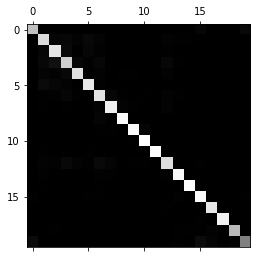

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

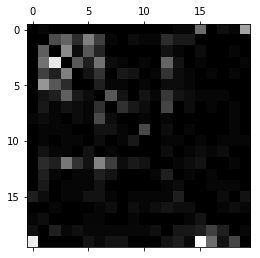

In [74]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [75]:
label_encoder.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

## Shortcuts in sklearn - pipelines
Sklearn allows us to build convenient `Pipelines`, which facilitate the management of our data and the training of our models enourmously. Consider for ex

In [76]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb_clf', MultinomialNB())
])

We could even replace the two first lines of the pipeline by using `TfidfVectorizer`, which first fits and transforms the input the same way as `CountVectorizer` followed by `TfidfTransformer`.

In [78]:
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ar_tf=False, use_idf=True)), ('nb_clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [79]:
scores = cross_val_score(text_clf, X_train, y_train, scoring='accuracy', cv=10)

In [80]:
scores

array([0.85526316, 0.8602812 , 0.8427065 , 0.8459507 , 0.85689046,
       0.8591674 , 0.84485816, 0.84991119, 0.84519573, 0.84861977])

## Model selection - find your best model
For every model you would like to train, there is a plethora of parameters you could set. How to find the best model? Sklearn has a solution: `GridSearchCV`. 

With grid search cross validation, you can define your hyperparameter space and train different models with all the parameter combinations. Keep in mind that depending on how many folds you train, the whole training procedure can take significantly longer.

In [82]:
from sklearn.model_selection import GridSearchCV

text_svc = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svc', LinearSVC())
])

param_grid = {'vect__ngram_range': [(1, 1), (1, 2)],
             'svc__loss': ['hinge', 'squared_hinge'],
             'svc__multi_class': ['ovr', 'crammer_singer']}

gs_svc = GridSearchCV(text_svc, param_grid, cv=5, n_jobs=4, verbose=1)
gs_svc.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 50.5min finished
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2)], 'svc__loss': ['hinge', 'squared_hinge'], 'svc__multi_class': ['ovr', 'crammer_singer']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [60]:
svc_df = pd.DataFrame.from_dict(gs_svc.cv_results_)
svc_df.sort_values(by=["rank_test_score"])

/home/phillip/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/phillip/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/phillip/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/phillip/anaconda3/lib/py

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_svc__loss,param_svc__multi_class,param_vect__ngram_range,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,686.134789,3.743508,0.930705,0.999403,hinge,crammer_singer,"(1, 2)","{'svc__loss': 'hinge', 'svc__multi_class': 'cr...",1,0.937417,...,0.924912,0.999558,0.926991,0.999116,0.934368,0.999669,286.866087,0.126190,0.004619,0.000193
7,662.552173,2.885766,0.930705,0.999359,squared_hinge,crammer_singer,"(1, 2)","{'svc__loss': 'squared_hinge', 'svc__multi_cla...",1,0.937417,...,0.924912,0.999448,0.926991,0.999006,0.934368,0.999669,208.876589,0.894399,0.004619,0.000214
5,57.669994,3.633046,0.930263,0.999669,squared_hinge,ovr,"(1, 2)","{'svc__loss': 'squared_hinge', 'svc__multi_cla...",3,0.936536,...,0.924028,0.999669,0.923451,0.999558,0.932151,0.999890,1.424082,0.317880,0.005513,0.000121
1,339.978553,3.932459,0.928938,0.998387,hinge,ovr,"(1, 2)","{'svc__loss': 'hinge', 'svc__multi_class': 'ov...",4,0.934332,...,0.926237,0.998232,0.921239,0.998012,0.930377,0.999007,47.562352,0.643115,0.004697,0.000332
4,12.755919,1.589989,0.924607,0.999138,squared_hinge,ovr,"(1, 1)","{'svc__loss': 'squared_hinge', 'svc__multi_cla...",5,0.929925,...,0.924912,0.999227,0.915044,0.999006,0.925055,0.999448,0.882834,0.366745,0.005138,0.000190
0,55.151473,1.638614,0.924342,0.995139,hinge,ovr,"(1, 1)","{'svc__loss': 'hinge', 'svc__multi_class': 'ov...",6,0.930366,...,0.924028,0.995359,0.913717,0.994478,0.927273,0.995474,9.684970,0.225647,0.005686,0.000363
2,184.052793,1.491734,0.924076,0.998564,hinge,crammer_singer,"(1, 1)","{'svc__loss': 'hinge', 'svc__multi_class': 'cr...",7,0.929044,...,0.922261,0.998674,0.919469,0.998343,0.926829,0.999117,52.200238,0.116839,0.003420,0.000313
6,185.887219,1.562905,0.924076,0.998564,squared_hinge,crammer_singer,"(1, 1)","{'svc__loss': 'squared_hinge', 'svc__multi_cla...",7,0.929044,...,0.922261,0.998674,0.919469,0.998343,0.926829,0.999117,41.081316,0.157256,0.003420,0.000313


In [62]:
gs_svc.predict(X_test)

array([ 3,  2, 17, ...,  9,  1,  2])

In [63]:
y_test

array([ 3,  2, 17, ...,  9,  1,  6])

In [64]:
best_model = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('svc', LinearSVC(loss='hinge', multi_class='crammer_singer'))
])

best_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...0,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0))])

In [65]:
best_model.predict(X_test)

array([ 3,  2, 17, ...,  9,  1,  2])

In [66]:
correct = 0

for index, prediction in enumerate(best_model.predict(X_test)):
    if prediction == y_test[index]:
        correct +=1

print('Accuracy: ', correct/y_test.shape[0])

Accuracy:  0.8600637280934679
